# Process
In this notebook, we will inspect how popularity relates to country distribution in the data.

## A. Import Libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import random as rd
import pandas as pd
import numpy as np
from split_users import split
from collections import Counter
from scipy import stats

## B. Set hyperparameters
There are certain hyperparameters that need to be tuned before the run. 

In [2]:
item_col = "ISBN" # the item column
user_col = "User-ID" # the user columns
my_seed = 0 # random_seed
split_country_by = "ratio_USA"
top_fraction_items = 0.2 # the limit for an item to be considered popular

In [3]:
rd.seed(my_seed) #seed for random functions
np.random.seed(my_seed) #seed for all numpy fuctions

## C. Read files

In [4]:
processed_file_location = "data/processed/" # here we store the processed data files

Popularity

In [5]:
df_item_dist= pd.read_csv(processed_file_location + "/item_pop_dist.csv", index_col=0)

In [6]:
low_popularity_users = pd.read_csv(processed_file_location +"/low_users.csv", index_col=0)
med_popularity_users = pd.read_csv(processed_file_location  +"/med_users.csv", index_col=0)
high_popularity_users = pd.read_csv(processed_file_location +"/high_users.csv", index_col=0)

Ratings

In [7]:
ratings = pd.read_csv(processed_file_location + "/final_fairbook_ratings.csv")

In [8]:
country_dict = {}
for ISBN in ratings[item_col].unique():
    country_dict[ISBN] = ratings.country[ratings[item_col] == ISBN].iloc[0]

## D. Compare country with 'popular' items

In [9]:
df_item_dist["country"] = ""

for index, row in df_item_dist.iterrows():
    country = country_dict[index]
    df_item_dist.at[index, "country"] = country

In [10]:
num_pop_items = int(top_fraction_items * len(df_item_dist))


The items and ratings that are considered popular:

In [15]:
pop_item_dist = df_item_dist.iloc[:num_pop_items] #items

In [16]:
pop_ratings = ratings[ratings[item_col].isin(list(pop_item_dist.index))] #ratings

In [40]:
colors={'USA':'#1f77b4', 
        'UK':'#d62728',
       "Ireland":"#8c564b",
       "unknown":"#ff7f0e",
       "Canada":"#9467bd",
       "other":"#2ca02c"}

In [37]:
dfs = [df_item_dist, pop_item_dist, ratings, pop_ratings]
dfs_names = ["all fairbook items", "fairbook popular items",
           "all fairbook ratings", "ratings of fairbook popular items"]

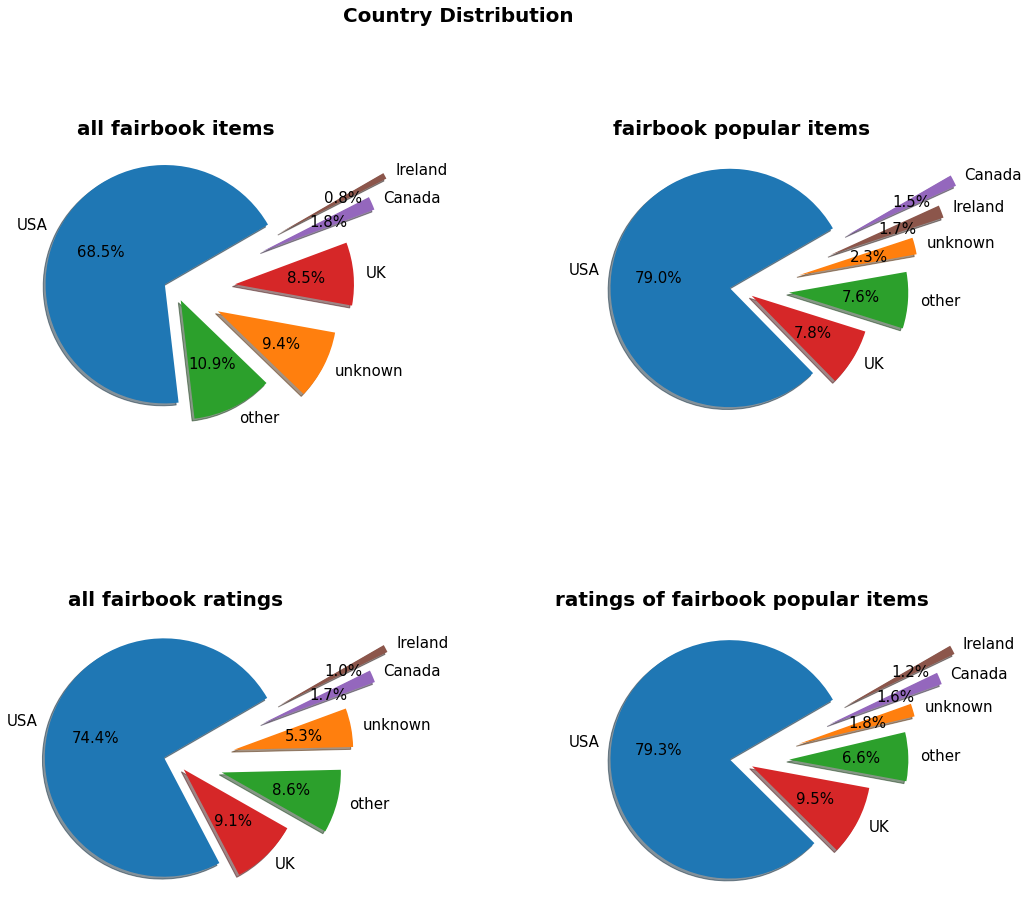

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
for i in range(len(dfs)):
    j1 = np.divide(i,2)
    j2 = np.mod(i,2)
    dfs[i].country.value_counts().plot(kind="pie",autopct='%1.1f%%',explode=(0.1, 0.1, 0.4,0.5, 0.8,1), shadow=True
                                      , startangle=30, ax=axes[int(j1),int(j2)],
                                      textprops={'color':'black', 'fontsize':15},
                                     colors=[colors[v] for v in dfs[i]['country'].value_counts().keys()])
    axes[int(j1),int(j2)].tick_params(labelrotation=0)
    axes[int(j1),int(j2)].set_title(dfs_names[i],fontdict={'fontsize':20, 'weight':'bold'})
    axes[int(j1),int(j2)].set_ylabel('')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.9, 
                    hspace=0.2)

fig.suptitle('Country Distribution',fontsize = 20, weight="bold") 
plt.show()

We observe that USA authors are overrepresented in items deemed "popular".

## E. Compare USA citizenship with popularity for items

### Point biserial correlation

In [22]:
df_item_dist_test = df_item_dist.copy()

In [23]:
df_item_dist_test.country = df_item_dist_test.country.apply(lambda x: 1 if x == "USA" else 0)

In [24]:
stats.pointbiserialr(df_item_dist_test.country.values, df_item_dist_test["count"].values)

PointbiserialrResult(correlation=0.0912897482687567, pvalue=1.158264841039079e-11)

### T test

Including "unknown" values.

In [26]:
USA_popularity = df_item_dist["count"][df_item_dist.country == "USA"].values
nonUSA_popularity = df_item_dist["count"][df_item_dist.country != "USA"].values

In [28]:
stats.ttest_ind(USA_popularity, nonUSA_popularity)

Ttest_indResult(statistic=6.799853420348795, pvalue=1.1582648410423848e-11)

Excluding "unknown" values.

In [25]:
df_non_unknowns = df_item_dist[df_item_dist.country!="unknown"]

In [29]:
USA_popularity = df_non_unknowns["count"][df_non_unknowns.country == "USA"].values
nonUSA_popularity = df_non_unknowns["count"][df_non_unknowns.country != "USA"].values

In [31]:
stats.ttest_ind(USA_popularity, nonUSA_popularity)

Ttest_indResult(statistic=3.4805615971537867, pvalue=0.0005046494342344799)

In any case, we see there is a significant difference in average popularity between the items written by USA citizens and non USA citizens.